In [1]:
# Example - https://github.com/cornelliusyudhawijaya/Churn_Causality_Analysis/blob/main/Causal%20Analysis%20Do%20Why.ipynb
    
import numpy as np
import pandas as pd

from dowhy import CausalModel
import dowhy.datasets 

# Avoid printing dataconversion warnings from sklearn and numpy
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings('ignore')

# Prepare Data

In [2]:
dataset_orig = pd.read_csv('../../../data/default.csv')

## Drop NULL values
data = data.dropna()

## for dowhy

data['sex'] = np.where(data['sex'] == 2, 0,1)

non_numeric_columns = list(data.select_dtypes(exclude=[np.number]).columns)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in non_numeric_columns:
    data[col] = le.fit_transform(data[col])

print(non_numeric_columns)

from sklearn.preprocessing import MinMaxScaler,StandardScaler

scaler = MinMaxScaler()
dataset_orig = pd.DataFrame(scaler.fit_transform(dataset_orig),columns = dataset_orig.columns)

## Reduce the data size to take a smaller sample

dataset_orig = dataset_orig.sample(5000)

protected_attribute = "sex"
(dataset_orig.head(5))

,LIMIT_BAL,sex,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Probability
5115,0.010101,1.0,0.333333,0.666667,0.172414,0.7,0.6,0.5,0.6,0.5,...,0.179149,0.100317,0.270199,0.000000,0.000326,0.000000,0.000000,0.000000,0.000000,0.0
6640,0.121212,1.0,0.166667,0.666667,0.155172,0.2,0.2,0.2,0.2,0.2,...,0.282435,0.204973,0.356994,0.007441,0.002791,0.005580,0.007407,0.012191,0.008512,1.0
21877,0.131313,0.0,0.166667,0.666667,0.051724,0.2,0.2,0.2,0.2,0.2,...,0.190844,0.113625,0.287922,0.002290,0.000904,0.002232,0.002415,0.005861,0.003783,0.0
18923,0.060606,0.0,0.333333,0.666667,0.137931,0.2,0.2,0.2,0.2,0.2,...,0.219283,0.137490,0.302027,0.057243,0.001373,0.002497,0.003282,0.004689,0.004023,0.0
20502,0.202020,1.0,0.500000,0.666667,0.120690,0.2,0.2,0.2,0.2,0.2,...,0.217611,0.141230,0.310998,0.002412,0.001781,0.003348,0.004026,0.014067,0.015132,0.0


# Transform data using LFR

In [4]:
from aif360.algorithms.preprocessing.lfr import LFR
from aif360.datasets import BinaryLabelDataset
from IPython.display import Markdown, display
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

protected_attribute = "sex"
dataset_orig_train, dataset_orig_test = train_test_split(dataset_orig, test_size=0.2)
privileged_groups = [{protected_attribute: 1}]
unprivileged_groups = [{protected_attribute: 0}]

TR = LFR(unprivileged_groups=unprivileged_groups,
         privileged_groups=privileged_groups,
#          k=10, Ax=.1, Ay=1.0, Az=2.0,
         verbose=1)

dataset_orig_train = BinaryLabelDataset(df=dataset_orig_train, label_names=['Probability'], protected_attribute_names=[protected_attribute])

TR.fit(dataset_orig_train, maxiter=1000, maxfun=1000)

dataset_transf = TR.transform(dataset_orig_train)
dataset_orig_train, yy = dataset_transf.convert_to_dataframe()

from sklearn.linear_model import LogisticRegression
from Measure import measure_final_score,calculate_recall,calculate_far,calculate_precision,calculate_accuracy

X_train, y_train =  dataset_orig_train.loc[:, dataset_orig_train.columns != 'Probability'], dataset_orig_train['Probability']
X_test, y_test = dataset_orig_test.loc[:, dataset_orig_test.columns != 'Probability'], dataset_orig_test['Probability']
        
clf = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100) # LSR
clf.fit(X_train,y_train)

print("aod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'aod'))
print("eod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'eod'))
print("SPD:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'SPD'))
print("DI:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'DI'))

step: 0, loss: 1.2354341209332427, L_x: 0.3494053909048122,  L_y: 0.7853782994924343,  L_z: 0.008931235350635202
step: 250, loss: 0.9601730078463442, L_x: 0.35067648919369543,  L_y: 0.7348936634274166,  L_z: 0.004435451590539813
step: 500, loss: 0.8814668909743035, L_x: 0.3509386590911687,  L_y: 0.7182449965354781,  L_z: 0.003194250156958273
step: 750, loss: 0.8834969332386848, L_x: 0.35103429175774636,  L_y: 0.7080727875186638,  L_z: 0.0034382760560488722
step: 1000, loss: 0.8119508556079068, L_x: 0.35080846894593265,  L_y: 0.7127700327806783,  L_z: 0.0019134547627553844
aod :sex 0.0
eod :sex 0.0
SPD: 0.0
DI: 0.0


# Graph

In [18]:
causal_graph = """
digraph {
AGE;
sex;
MARRIAGE;
EDUCATION;
Probability;
U[label="Unobserved Confounders"];

sex -> Probability;
sex -> EDUCATION; EDUCATION -> Probability;
sex -> MARRIAGE; MARRIAGE -> Probability;
AGE -> EDUCATION; AGE -> MARRIAGE;
U->sex;U->Probability;
}
"""

## dowhy works for binary inputs only

df['Probability'] = np.where(df['Probability'] == 0, False, True)
df[protected_attribute] = np.where(df[protected_attribute] == 1, True, False)

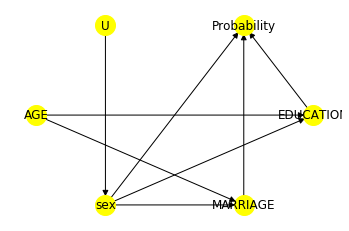

In [15]:
# With graph
model=CausalModel(
        data = df,
        treatment=protected_attribute,
        outcome="Probability",
        graph=causal_graph.replace("\n", " ")
        )
model.view_model()

In [16]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
──────(Expectation(Probability|AGE))
d[sex]                              
Estimand assumption 1, Unconfoundedness: If U→{sex} and U→Probability then P(Probability|sex,AGE,U) = P(Probability|sex,AGE)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(Probability, [U])*Derivative([sex], [U])**(-1))
Estimand assumption 1, As-if-random: If U→→Probability then ¬(U →→{U})
Estimand assumption 2, Exclusion: If we remove {U}→{sex}, then ¬({U}→Probability)

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [17]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
──────(Expectation(Probability|AGE))
d[sex]                              
Estimand assumption 1, Unconfoundedness: If U→{sex} and U→Probability then P(Probability|sex,AGE,U) = P(Probability|sex,AGE)

## Realized estimand
b: Probability~sex+AGE
Target units: ate

## Estimate
Mean value: 0.0

Causal Estimate is 0.0


In [ ]:
# Causal effect on the control group (ATC)
causal_estimate_att = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        target_units = "atc")
print(causal_estimate_att)
print("Causal Estimate is " + str(causal_estimate_att.value))

# Add Random Common Cause

In [10]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "random_common_cause")
print(refutel)

Refute: Add a Random Common Cause
Estimated effect:0.0
New effect:0.0



# Replace Treatment with Placebo

In [11]:
refutel = model.refute_estimate(identified_estimand,causal_estimate,method_name="placebo_treatment_refuter",placebo_type="permute")
print(refutel)

Refute: Use a Placebo Treatment
Estimated effect:0.0
New effect:0.0
p value:1.0



# Remove Random Subset of Data

In [12]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "data_subset_refuter")
print(refutel)

Refute: Use a subset of data
Estimated effect:0.0
New effect:0.0
p value:1.0

